### Code Hist.

 - CODE  
    &ensp; : Crawling - 특일 정보 조회 (KASI)

  - DATE  
    &ensp; 2023-11-29 Created  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 1)   
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 2)    
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; 3)   
    
 - DESC  
    &ensp; : 전처리 - 한국지역난방공사 열판매량/열공급량   
    &emsp; 1) 결측치가 없어서, 그대로 사용  
    &emsp;&ensp;&ensp; 
    &emsp;&ensp;&ensp; (Crawl Code 없음)   
    &emsp; 2) 

 - DATA  
    &emsp; <"Input">  
    1) None (Input Dataset)  
    &emsp;- Period :   
    &emsp;- Interval : 

    &emsp; <"Output">  
    1) Hourly (관측소/년도별 출력)  
    &nbsp;df_data_cal.to_csv(data_dir + 'KASI_DATE_D_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    2) Daily (관측소/년도별 출력)  
    &nbsp;df_data_cal_24.to_csv(data_dir + 'KASI_DATE_H_Final.csv', index = False, encoding='utf-8-sig')  
    &emsp;- Columns : ['locdate', 'YEAR', 'MONTH', 'DAY'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'dateKind', 'code_day_of_the_week', 'day_of_the_week'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'rest_YN', 'name_of_holiday', 'dist_from_holiday'  
    &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;, 'HOUR', 'MINUTE']
    &emsp;- Period :   
    &emsp;- Interval :  
    
    

 - Related Link  
    &ensp; : 

# 01. Code

## 01-01. Init

### 01-01-01. Init_Module Import

In [1]:
#region Basic_Import
## Basic
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import random
from pandas import DataFrame, Series

## Datetime
import time
import datetime as dt
from datetime import datetime, date, timedelta

import glob
from glob import glob
import requests
import json

## 시각화
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 8]

from scipy import stats

## TSNE
from sklearn.datasets import load_digits
from sklearn.manifold import TSNE

## 정규화
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
## Modeling, Model Training
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
## Model 평가
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score   # model.score   

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [2]:
## Import_DL
str_tar = "tf"
## For Torch
if str_tar == "torch":
    import torch
    import torch.nn as nn
    from torch.nn.utils import weight_norm
    print("Torch Imported")
## For TF
elif str_tar == "tf":
    import tensorflow as tf
    import tensorflow_addons as tfa
    print("Tensorflow Imported")
else:
    print("Error : Cannot be used except for Keywords")
    print(" : torch / tf")

Tensorflow Imported


In [3]:
# !pip install lightgbm

## LGBM
# import lightgbm as lgbm
# from lightgbm import LGBMRegressor

## XGB
## https://magoker.tistory.com/106
import xgboost as xgb
from xgboost import plot_importance, plot_tree, XGBClassifier

In [4]:
## Import_Local (현재 프로그램에서 미사용)
from DEV_Common_Data_Analysis import print_desc_statistic
from DEV_Common_Data_Datetime import create_col_ymdhm, create_col_datetime, create_df_dt, conv_midnight_24to00, create_col_weekdays #, validate_date, list_invalidDate, calc_df_dt
from DEV_Common_Data_Preprocessing import resample_by_last, find_outlier_Usages, del_outlier_Usages
from DEV_Common_Data_Visualization import visualization_df
from DEV_KASI_Holiday import KASI_holiDay, KASI_restDay, KASI_anniDay
from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA
from DEV_KDHC_Usage import KDHC_HEAT_Usage

### 01-01-02. Config (Directory, Params)

In [5]:
## Init_config
SEED = 42

np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = "1"
random.seed(SEED)

In [6]:
## Define Todate str
str_now_ymd = pd.datetime.now().date()
str_now_y = pd.datetime.now().year
str_now_m = pd.datetime.now().month
str_now_d = pd.datetime.now().day
str_now_hr = pd.datetime.now().hour
str_now_min = pd.datetime.now().minute

print(pd.datetime.now())
print(str(str_now_y) + " / " + str(str_now_m)  + " / " + str(str_now_d))
print(str(str_now_hr) + " : " + str(str_now_min))

2023-11-30 05:19:31.611180
2023 / 11 / 30
5 : 19


## 01-02. Data Load (df_raw)

### 01-02-01. KDHC Heat Usage

In [7]:
# Define data root directory
str_dir_kdhcHeat = "./data_Energy_KDHC_National_Heat/"
print(os.listdir(str_dir_kdhcHeat))

df_kdhc_heat = pd.read_csv(str_dir_kdhcHeat + 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', index_col = 0)
df_kdhc_heat

['DATA_KDHC_Heat_Provide_Cheongju_2010_2021.csv', 'DATA_KDHC_Heat_Provide_Cheongju_2010_2021_1st_Check.csv', 'DATA_KDHC_Heat_Provide_Sejong_2014_2018.csv', 'DATA_KDHC_Heat_Provide_Sejong_2014_2018_1st_Check.csv', 'DATA_KDHC_Heat_Sell_Branch_201910_202109.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_complete_analysis.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_linearReg.csv', 'KDHC_COMB_HEATxWEATHER_2019-2022_mean_imp.csv', 'KDHC_NATIONAL_HEAT_hr.csv', 'KDHC_NATIONAL_HEAT_RAW_hr.csv']


,METER_DATE,day_of_the_week,YEAR,MONTH,DAY,HOUR,MINUTE,code_day_of_the_week,rest_YN,dist_from_holiday,...,SUWON,HWASUNG,DONGTAN,PYONGTAEK,CHEONGJU,SEJONG,KIMHAE,DAEGU,YANGSAN,GWANGJU_JEONNAM
0,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
1,2019-10-01 01:00:00,Tuesday,2019,10,1,1,0,1,0,2,...,26.0000000000,11.0000000000,21,0.5000000000,16,18.0000000000,8,19.0000000000,10,3
2,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
3,2019-10-01 02:00:00,Tuesday,2019,10,1,2,0,1,0,2,...,29.0000000000,12.0000000000,16,0.5000000000,13,15.0000000000,7,16.0000000000,9,2
4,2019-10-01 03:00:00,Tuesday,2019,10,1,3,0,1,0,2,...,33.0000000000,12.0000000000,14,0.5000000000,10,15.0000000000,7,15.0000000000,8,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27298,2022-09-30 20:00:00,Friday,2022,9,30,20,0,4,0,1,...,73.0000000000,39.0000000000,61,12.0000000000,36,44.0000000000,12,30.0000000000,18,6
27299,2022-09-30 21:00:00,Friday,2022,9,30,21,0,4,0,1,...,71.0000000000,36.0000000000,55,4.0000000000,30,44.0000000000,11,35.0000000000,22,5
27300,2022-09-30 22:00:00,Friday,2022,9,30,22,0,4,0,1,...,65.0000000000,29.0000000000,45,2.0000000000,27,43.0000000000,12,32.0000000000,22,6
27301,2022-09-30 23:00:00,Friday,2022,9,30,23,0,4,0,1,...,64.0000000000,25.0000000000,32,3.0000000000,25,40.0000000000,11,34.0000000000,22,6


In [8]:
# df_kdhc_heat = df_kdhc_heat[['METER_DATE', 'YEAR', 'MONTH', 'DAY', 'day_of_the_week', 'code_day_of_the_week'
#                              , 'HOUR', 'MINUTE', 'rest_YN', 'dist_from_holiday'
#                              , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
#                              , 'humidity'
#                              , 'rainfall', 'snowfall', 'snowfall_3hr'
#                              , 'wind_speed', 'wind_direction'
#                              , 'pressure_vapor', 'pressure_area', 'pressure_sea'
#                              , 'sunshine', 'solar_radiation'
#                              , 'cloud_total', 'cloud_midlow'
#                              , 'visual_range'
#                              , 'PAJU', 'GOYANG', 'SAMSONG'
#                              , 'JOONGANG'
#                              , 'KANGNAM'
#                              , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN'
#                              , 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
#                              , 'KIMHAE', 'DAEGU', 'YANGSAN'
#                              , 'GWANGJU_JEONNAM']]

df_kdhc_heat = df_kdhc_heat[['YEAR', 'MONTH', 'DAY', 'code_day_of_the_week'
                             , 'HOUR', 'MINUTE', 'rest_YN', 'dist_from_holiday'
                             , 'temp_outdoor', 'temp_dew_point', 'temp_ground'
                             , 'humidity'
                             , 'rainfall', 'snowfall', 'snowfall_3hr'
                             , 'wind_speed', 'wind_direction'
                             , 'pressure_vapor', 'pressure_area', 'pressure_sea'
                             , 'sunshine', 'solar_radiation'
                             , 'cloud_total', 'cloud_midlow'
                             , 'visual_range'
                            #  , 'PAJU', 'GOYANG', 'SAMSONG'
                            #  , 'JOONGANG'
                            #  , 'KANGNAM'
                            #  , 'PANGYO', 'BUNDANG', 'YONGIN', 'GWANGGYO', 'SUWON', 'HWASUNG', 'DONGTAN'
                             , 'PYONGTAEK', 'CHEONGJU', 'SEJONG'
                            #  , 'KIMHAE', 'DAEGU', 'YANGSAN'
                            #  , 'GWANGJU_JEONNAM'
                             ]]
col_tar = 'PYONGTAEK'

In [9]:
for i in range(0, len(df_kdhc_heat)):
    if df_kdhc_heat['rest_YN'].iloc[i] == 'N':
        df_kdhc_heat['rest_YN'].iloc[i] = 0
    elif df_kdhc_heat['rest_YN'].iloc[i] == 'Y':
        df_kdhc_heat['rest_YN'].iloc[i] = 1
df_kdhc_heat['rest_YN'] = df_kdhc_heat['rest_YN'].astype(int)

In [10]:
for i in range(0, len(df_kdhc_heat)):
    if df_kdhc_heat['dist_from_holiday'].iloc[i] == '제헌절':
        df_kdhc_heat['dist_from_holiday'].iloc[i] = 0
    # elif df_kdhc_heat['rest_YN'].iloc[i] == 'Y':
        # df_kdhc_heat['rest_YN'].iloc[i] = 1

df_kdhc_heat['dist_from_holiday'] = df_kdhc_heat['dist_from_holiday'].astype(int)

In [11]:
X = df_kdhc_heat.drop([col_tar], axis=1)
Y = df_kdhc_heat[[col_tar]]

In [12]:
trainSet, testSet = train_test_split(df_kdhc_heat, test_size=0.3, shuffle=False)
print(trainSet.shape, testSet.shape)

(19097, 28) (8185, 28)


In [13]:
trainXX = trainSet.drop([col_tar],axis=1)
trainYY = trainSet[[col_tar]]

testXX = testSet.drop([col_tar],axis=1)
testYY = testSet[[col_tar]]

In [14]:
trainXXindex = trainXX.index
trainXXcolumns = trainXX.columns

trainYYindex = trainYY.index
trainYYcolumns = trainYY.columns

testXXindex = testXX.index
testXXcolumns = testXX.columns

testYYindex = testYY.index
testYYcolumns = testYY.columns

In [15]:
d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
# d_trainXX=pd.DataFrame(trainXX, index=trainXXindex, columns=trainXXcolumns)
d_trainYY=trainYY

#d_valX=pd.DataFrame(func_valSet, index=valXindex, columns=valXcolumns)
#d_valY=valY

d_testXX=pd.DataFrame(testXX, index=testXXindex, columns=testXXcolumns)
# d_testXX=pd.DataFrame(trainXX, index=testXXindex, columns=testXXcolumns)
d_testYY=testYY

In [16]:
params = {
    'learning_rate': 0.01,
    'objective': 'regression',
    'metric':'mae',
    'seed':42
}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

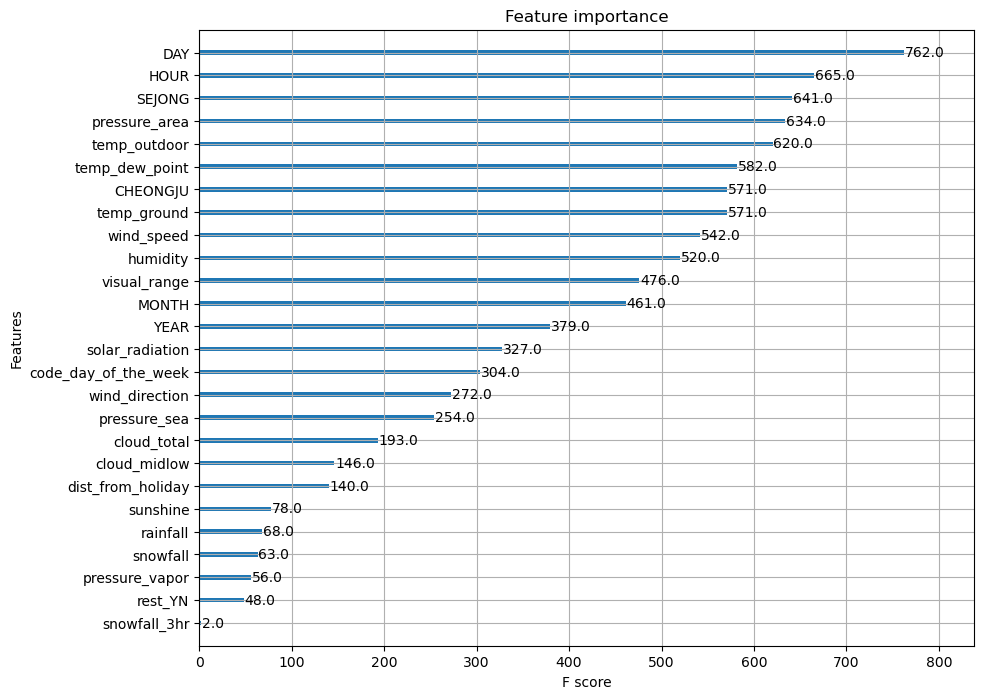

In [17]:
XGB_CJ = xgb.XGBRegressor(n_estimators = 1000)
XGB_CJ.fit(d_trainXX, d_trainYY
           , eval_set=[(d_testXX, d_testYY)]
           , early_stopping_rounds = 50, verbose = False)

## 주요 변수 판단
plot_importance(XGB_CJ)

In [18]:
XGB_pred = XGB_CJ.predict(d_testXX)
XGB_pred = np.reshape(XGB_pred,(-1,1))

In [19]:
d_actual = testYY.to_numpy()
d_actual = np.reshape(d_actual,(-1,1))

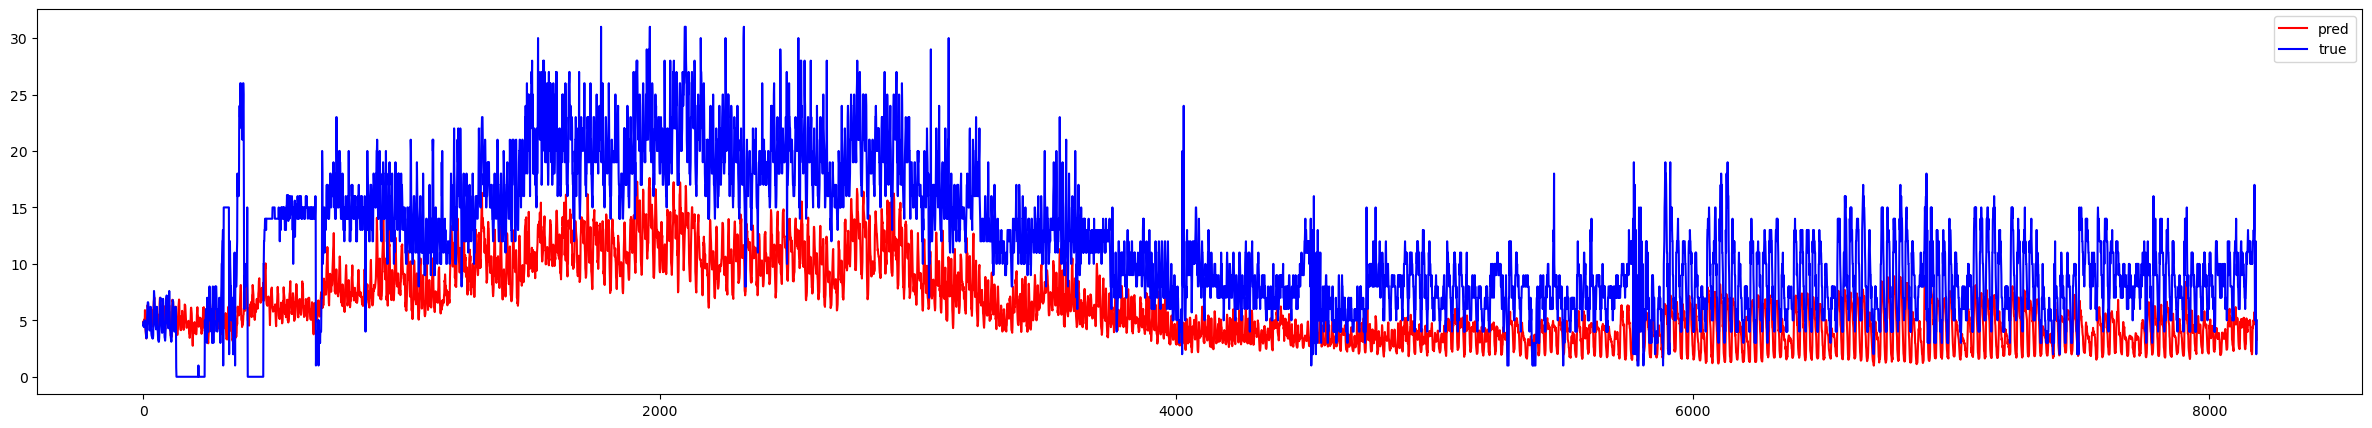

In [20]:
plt.figure(figsize=(30,5))
plt.plot(XGB_pred,color='red',label='pred')
plt.plot(d_actual,color='blue',label='true')
plt.legend()
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_percentage_error
print('mean_absolute_percentage_error : ', mean_absolute_percentage_error(d_actual, XGB_pred))

from sklearn.metrics import mean_absolute_error
print('mean_absolute_error : ', mean_absolute_error(d_actual, XGB_pred))                                      

from sklearn.metrics import mean_squared_error
print('mean_squared_error : ', mean_squared_error(d_actual, XGB_pred))

from sklearn.metrics import r2_score   # model.score
print('r2_score : ', r2_score(d_actual, XGB_pred))

mean_absolute_percentage_error :  506226908966078.3
mean_absolute_error :  5.587307315373756
mean_squared_error :  39.90548177126961
r2_score :  -0.148696880708576
